# Packages Installs, imports, and presets

In [1]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model
import torch
#import shap
#from torchsummary import summary

/home/hwerneck/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [ ]:
INPUT_SIZE = (256,256,3)

# Data loading

In [70]:
def get_attack_directory_attack(path):
  return path[29:]
attacks_directories= [
                      '20200425_UOWM_IEC104_Dataset_m_sp_na_1_DoS',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1',
                      '20200427_UOWM_IEC104_Dataset_c_se_na_1',
                      '20200428_UOWM_IEC104_Dataset_c_sc_na_1',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1',
                      '20200426_UOWM_IEC104_Dataset_c_ci_na_1_DoS',
                      '20200605_UOWM_IEC104_Dataset_c_rd_na_1_DoS',
                      '20200606_UOWM_IEC104_Dataset_c_rp_na_1_DoS',
                      '20200428_UOWM_IEC104_Dataset_c_se_na_1_DoS',
                      '20200429_UOWM_IEC104_Dataset_c_sc_na_1_DoS',
                                            # '20200608_UOWM_IEC104_Dataset_mitm_drop'
                                            ]
get_attack_directory_attack(attacks_directories[0])

'm_sp_na_1_DoS'

In [71]:
df =pd.concat([pd.read_parquet(f"./data/{attack_directory}.parquet").sample(10000) for attack_directory in attacks_directories ])

In [72]:
# %%time
# from tqdm import tqdm
# from collections import defaultdict
# df=df.sort_values(by=['flow','tv_sec','tv_usec'],axis=0,ascending=True)

# TIMEOUT = 120

# last_timestamp = defaultdict(lambda: 0)
# flow_bin = defaultdict(lambda: 0)
# splits = []
# for c,r in tqdm(df.iterrows()):
#   flow_id = c+'_'+r['label']
#   if (r['tv_sec'] - last_timestamp[flow_id] ) >= TIMEOUT:# in the first packet of a flow it's always true
#     flow_bin[flow_id] += 1
#   splits.append(f"{flow_bin[flow_id]}_{flow_id}")
#   last_timestamp[flow_id] = r['tv_sec']
# df['flow'] = splits
# del splits
# df=df.set_index('flow')


0it [00:00, ?it/s]
1it [00:02,  2.81s/it]
1348it [00:02, 651.35it/s]
2167it [00:03, 1137.10it/s]
2966it [00:04, 940.31it/s] 
3764it [00:04, 1376.65it/s]
4726it [00:04, 2047.09it/s]
5459it [00:04, 2530.40it/s]
6144it [00:04, 3015.76it/s]
6886it [00:04, 3678.55it/s]
7789it [00:04, 4625.50it/s]
8540it [00:04, 5047.18it/s]
9378it [00:04, 5774.12it/s]
10134it [00:05, 5971.90it/s]
11021it [00:05, 6685.35it/s]
12055it [00:05, 7636.44it/s]
13052it [00:05, 8267.97it/s]
13948it [00:05, 8171.06it/s]
14813it [00:05, 7724.22it/s]
15641it [00:05, 7873.02it/s]
16457it [00:05, 7708.79it/s]
17285it [00:05, 7867.42it/s]
18087it [00:06, 7046.82it/s]
18817it [00:06, 4854.35it/s]
19407it [00:06, 4684.16it/s]
19947it [00:06, 4347.73it/s]
20644it [00:06, 4860.11it/s]
21311it [00:06, 5281.32it/s]
21888it [00:07, 4426.16it/s]
22384it [00:07, 4509.11it/s]
23135it [00:07, 5237.17it/s]
23704it [00:07, 5158.27it/s]
24251it [00:07, 4780.51it/s]
24754it [00:07, 4510.55it/s]
25223it [00:07, 4250.85it/s]
25661it [00:

CPU times: user 14.5 s, sys: 2.41 s, total: 16.9 s
Wall time: 24.7 s


## Removing missing features

In [73]:
df=df.drop([c for c,v in ((df==-1).sum() == len(df)).items() if v==True],axis=1)

In [74]:
df.shape

(110000, 803)

In [75]:
df['tv_sec']=df['tv_sec'].astype(int)
df['tv_usec']=df['tv_usec'].astype(int)

# Model training

## Dataset preparation

In [76]:
df[['label']].value_counts()

label        
normal           76204
c_rd_na_1_DoS     4346
c_rp_na_1_DoS     4329
c_sc_na_1_DoS     4308
c_se_na_1_DoS     3523
c_ci_na_1_DoS     3291
c_rp_na_1         3163
c_rd_na_1         3122
c_se_na_1         2648
c_sc_na_1         2618
c_ci_na_1         2448
Name: count, dtype: int64

In [77]:
df[['label']]

,label
flow,
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
1_192.168.1.13_192.168.1.20_2404_49259_TCP_c_rp_na_1_normal,normal
...,...
1_192.168.1.29_192.168.1.22_46861_2404_TCP_c_sc_na_1_DoS_c_sc_na_1_DoS,c_sc_na_1_DoS
1_192.168.1.29_192.168.1.22_46861_2404_TCP_c_sc_na_1_DoS_c_sc_na_1_DoS,c_sc_na_1_DoS
1_192.168.1.29_192.168.1.22_46871_2404_TCP_c_sc_na_1_c_sc_na_1,c_sc_na_1


In [78]:
from feature_engine.encoding import OrdinalEncoder

In [79]:
od = OrdinalEncoder(encoding_method='arbitrary')
od.fit(df[['label']])
df[['label']]= od.transform(df[['label']])

In [80]:
TRAIN_RATE= 0.8
import random
indexes = list(set(df.index))
random.shuffle(indexes)
TRAIN_SIZE = int(len(indexes)*TRAIN_RATE)
TEST_SIZE = len(indexes)-TRAIN_SIZE
TRAIN_SAMPLES = indexes[:TRAIN_SIZE]
TEST_SAMPLES = indexes[:TEST_SIZE]
df_train_initial = df.loc[TRAIN_SAMPLES]
df_test = df.loc[TEST_SAMPLES]
# df_test = df.iloc[TRAIN_SAMPLES:]
# del df

In [81]:
indexes = list(set(df_train_initial.index))
random.shuffle(indexes)
TRAIN_SIZE = int(len(indexes)*TRAIN_RATE)
TEST_SIZE = len(indexes)-TRAIN_SIZE
TRAIN_SAMPLES = indexes[:TRAIN_SIZE]
TEST_SAMPLES = indexes[:TEST_SIZE]
df_train = df_train_initial.loc[TRAIN_SAMPLES]
df_validation = df_train_initial.loc[TEST_SAMPLES]

In [82]:
df_train.shape, df_validation.shape, df_test.shape

((90966, 803), (8905, 803), (10478, 803))

In [83]:
del df_train_initial
del df

In [84]:
# TRAIN_SIZE = 0.7
# tmp = random.shuffle(list(set(df_train.index)))
# TRAIN_SAMPLES = int(len(df_train)*TRAIN_SIZE)
# df_train,df_validation = df_train.iloc[:TRAIN_SAMPLES],df_train.iloc[TRAIN_SAMPLES:]

In [85]:
assert df_train.groupby(df_train.index)['label'].nunique().max()==1

#### Static vs Dynamic Packet (w.r.t. Flow) Features

In [86]:
# pat = '([\w\d_]+)_?\d*'
# pat=r"([\w_]+)_\d*"
pat=r"([\w_]+)_\d+"
tmp=df_train.iloc[:, df_train.columns != 'label'].T.reset_index().replace(to_replace=pat, value=r"\1", regex=True).groupby('index').agg(lambda x: ''.join(map(str,x))).T
tmp = tmp.groupby(tmp.index).nunique().max().to_frame().sort_values(by=0,ascending=False)

In [87]:
static_features= set(tmp.loc[tmp[0]==1].index)
dynamic_features = set(tmp.index) - static_features

In [88]:
dynamic_features_raw = {'tcp_opt','tv_sec','tv_usec','tcp_cksum','tcp_ackn','tcp_seq','ipv4_tl'}
dynamic_features_reduce =  dynamic_features - dynamic_features_raw

In [89]:
dynamic_features_raw,dynamic_features_reduce,static_features = list(dynamic_features_raw),list(dynamic_features_reduce),list(static_features)
dynamic_features=  list(dynamic_features)

In [90]:
# [i for i in df_train.columns if len([for i in dynamic_features]) > 0]
def get_bit_columns(features):
  dynamic_features_bit_columns= []
  for column_name in df_train.columns:
    for feature_name in features:
      if  feature_name in column_name:
        dynamic_features_bit_columns.append(column_name)
        break
  return dynamic_features_bit_columns

In [91]:
dynamic_features_bit_columns= get_bit_columns(dynamic_features)
static_features_bit_columns= get_bit_columns(static_features)

In [92]:
dynamic_features

['tcp_seq',
 'tcp_ackn',
 'ipv4_id',
 'tv_sec',
 'tcp_wsize',
 'ipv4_tl',
 'tcp_opt',
 'payload_bit',
 'ipv4_cksum',
 'tv_usec',
 'tcp_cksum']

In [93]:
num_dynamic_features = len(dynamic_features_bit_columns)
num_static_features= len(static_features_bit_columns)
num_dynamic_features, num_static_features

(626, 176)

In [94]:
from torch import optim
import lightning as L
import torch
import torch.nn as nn

In [95]:
len(set(df_train.index))

16875

In [96]:
df_train

,tv_sec,tv_usec,ipv4_ver_0,ipv4_ver_1,ipv4_ver_2,ipv4_ver_3,ipv4_hl_0,ipv4_hl_1,ipv4_hl_2,ipv4_hl_3,...,payload_bit_375,payload_bit_376,payload_bit_377,payload_bit_378,payload_bit_379,payload_bit_380,payload_bit_381,payload_bit_382,payload_bit_383,label
flow,,,,,,,,,,,,,,,,,,,,,
1_192.168.1.13_192.168.1.29_2404_43103_TCP_c_se_na_1_DoS_c_se_na_1_DoS,1588079934,436658,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
1_192.168.1.13_192.168.1.29_2404_43103_TCP_c_se_na_1_DoS_c_se_na_1_DoS,1588079944,453972,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
1_192.168.1.13_192.168.1.29_2404_43103_TCP_c_se_na_1_DoS_c_se_na_1_DoS,1588079954,470567,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
1_192.168.1.21_192.168.1.28_2404_43661_TCP_c_rd_na_1_c_rd_na_1,1591366965,971027,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1_192.168.1.22_192.168.1.29_2404_35465_TCP_c_rp_na_1_DoS_c_rp_na_1_DoS,1591467649,865561,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_192.168.1.26_192.168.1.27_2404_34265_TCP_c_se_na_1_DoS_c_se_na_1_DoS,1588080268,663134,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,5
1_192.168.1.27_192.168.1.25_34479_2404_TCP_c_sc_na_1_c_sc_na_1,1588108711,526618,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,9
1_192.168.1.26_192.168.1.27_2404_33461_TCP_c_se_na_1_c_se_na_1,1588005773,115259,0,1,0,0,0,1,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,6


## Training Dataset


In [97]:
import multiprocessing
multiprocessing.cpu_count()

2

In [156]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset

BATCH_SIZE=16

class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T

        if not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)

        return flow, label



# Your code for defining INPUT_SIZE and dynamic_features_bit_columns
# and static_features_bit_columns goes here


# result = feature_transform(flow)
# end_time = time.time()


# print("Execution time:", execution_time)
def feature_transform(flow):
    # start_time = time.time()
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Extract dynamic and static features
    dynamic_features = flow.loc[:, dynamic_features_bit_columns].values
    static_features = flow.loc[:, static_features_bit_columns].iloc[0].values

    # Convert to tensors
    dynamic_tensor = torch.tensor(dynamic_features, dtype=torch.float32)
    static_tensor = torch.tensor(static_features, dtype=torch.float32)

    # Determine the shape of the dynamic tensor
    dynamic_shape = dynamic_tensor.shape

    # Preallocate tensor for X with -1
    # print(INPUT_SIZE)
    total_dynamic_size = INPUT_SIZE[1] * INPUT_SIZE[2]
    X = -torch.ones(INPUT_SIZE[0], total_dynamic_size, dtype=torch.float32)

    # Fill in the dynamic features (ensure no size mismatch)
    min_shape_0 = min(dynamic_shape[0], INPUT_SIZE[0])
    # min_shape_1 =

    X[:min_shape_0, :dynamic_shape[1]] = dynamic_tensor[-min_shape_0:, :dynamic_shape[1]]

    # # If there are extra rows, truncate
    # if INPUT_SIZE[0] < dynamic_shape[0]:
    #     X = X[:INPUT_SIZE[0]]

    # Reshape X to the desired view
    X = X.view(3,256,256)
    # end_time = time.time()
    # execution_time = end_time - start_time
    # print("Execution time:", execution_time)
    X = (X+1)/2
    return [X, static_tensor]

NUM_WORKERS =2
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)

train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

## Model Design

In [157]:
model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()
import torchmetrics

In [158]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda"
    return device
DEVICE = get_device()

In [159]:

class FullyConnectedNet(nn.Module):
    def __init__(self,input_size,output_size,l1=180,l2=128,l3=20,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(input_size, l1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(l2, l3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(l3, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.net(x)
        return x

class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0]).last_hidden_state
        # print("Hidden states shape:", hidden_states.shape)
        # print("Additional input shape:", x[1].shape)
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        # print("Concatenated input shape:", concatenated_input.shape)
        return self.decoder(concatenated_input)
        # print(hidden_states.shape,x[1].shape)
        # return self.decoder(torch.concat((torch.flatten(hidden_states,start_dim=1), torch.flatten(x[1],start_dim=1))))


class LFVIT(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def training_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["train_"+key]=metrics.pop(key)
        self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        return metrics['train_loss']
    def forward(self, inputs):
        return self.model(inputs)
    def validation_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["val_"+key]=metrics.pop(key)
        self.log_dict(metrics,prog_bar=True,on_step=False, on_epoch=True)
        return metrics
    def test_step(self, batch, batch_idx):
        metrics = self._shared_eval_step(batch, batch_idx)
        for key,value in metrics.copy().items():
            metrics["test_"+key]=metrics.pop(key)
        self.log_dict(metrics)
        return metrics
    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        # dynamic_features, static_features  = x
        target_prediction = self.model(x)
        # print(target_prediction.shape,y.shape)
        # print(target_prediction)
        # print(x)
        metrics=dict()
        # print(target_prediction, y)
        metrics['loss'] = nn.functional.cross_entropy(target_prediction, y)
        # Initialize metrics
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        auc_roc = torchmetrics.AUROC(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        auc_pr = torchmetrics.AveragePrecision(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)

        # Compute metrics
        metrics['accuracy'] = accuracy(target_prediction, y)
        metrics['precision'] = precision(target_prediction, y)
        metrics['recall'] = recall(target_prediction, y)
        metrics['f1'] = f1(target_prediction, y)
        metrics['auc_roc'] = auc_roc(target_prediction, y)
        metrics['auc_pr'] = auc_pr(target_prediction, y)
        return metrics
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","monitor": "val_loss"}}


In [160]:
model_vitv2 = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")

decoder=FullyConnectedNet(np.prod(model_vitv2_output_shape)+num_static_features,NUM_CLASSES,l1=180,l2=128,l3=20,dropout=0.2)
fvit = FVIT(model_vitv2,decoder)
model_fvit = LFVIT(fvit)

In [161]:
#summary(fvit,(1,3,256,256))

In [162]:
NUM_CLASSES

11

In [163]:
# from pytorch_lightning.callbacks import Timer

In [164]:
MAX_EPOCHS=50
# timer =  L.pytorch.callbacks.Timer()
def run_autoencoder_trainer_fit(train_loader,validation_loader,model):
    checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
        monitor='train_loss',
        filename='iec104-{epoch:02d}-{loss:.2f}',
        save_top_k=3,
        mode='min',
    )

    early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[checkpoint_callback,early_stop_callback],accelerator=DEVICE,
                        devices=1,log_every_n_steps=10,limit_train_batches=0.1,limit_val_batches=20)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    return checkpoint_callback,trainer
checkpoint_callback,trainer=run_autoencoder_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type | Params
-------------------------------
0 | model | FVIT | 10.3 M
-------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.380    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [165]:
model_fvit

LFVIT(
  (model): FVIT(
    (encoder): MobileViTV2Model(
      (conv_stem): MobileViTV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (normalization): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (encoder): MobileViTV2Encoder(
        (layer): ModuleList(
          (0): MobileViTV2MobileNetLayer(
            (layer): ModuleList(
              (0): MobileViTV2InvertedResidual(
                (expand_1x1): MobileViTV2ConvLayer(
                  (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): SiLU()
                )
                (conv_3x3): MobileViTV2ConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gro

In [166]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


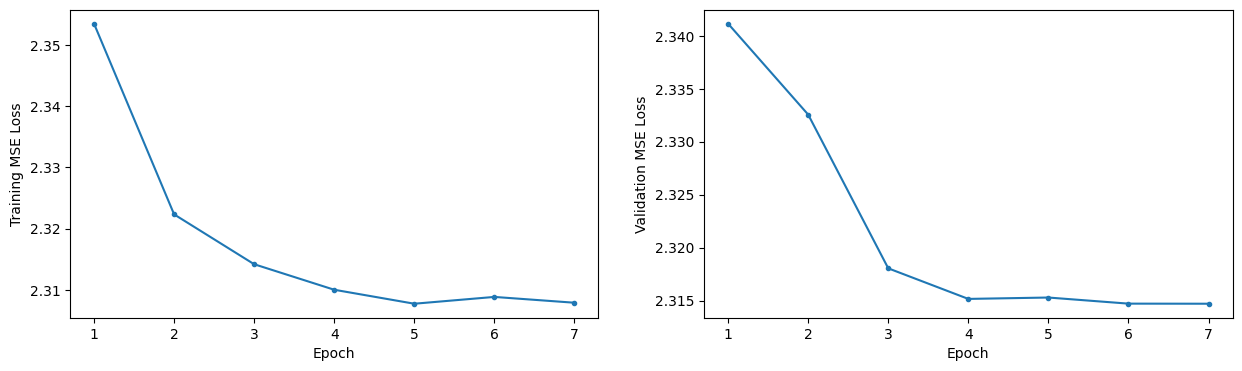

In [167]:
def plot_training_metrics(trainer,metrics,ax):
    event_acc = EventAccumulator(trainer.logger.log_dir)
    event_acc.Reload()
    for i in range(len(metrics)):
        y=[i.value for i in event_acc.Scalars(metrics[i]['name'])]
        x=np.arange(len(y))+1
        ax[i].plot(x,y,marker='.')
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel(metrics[i]['label'])
metrics=[{'name':'train_loss','label':'Training MSE Loss'},{'name':'val_loss','label':'Validation MSE Loss'}]
fig,ax = plt.subplots(ncols=len(metrics),figsize=(15,4))
plot_training_metrics(trainer,metrics,ax)

In [168]:
trainer.test(ckpt_path="best",dataloaders=test_loader)
# autoencoder = LAutoEncoder.load_from_checkpoint(checkpoint_callback.best_model_path,
#                                                 autoencoder=Autoencoder(1,LATENT_DIM))

INFO: Restoring states from the checkpoint path at /content/lightning_logs/version_35/checkpoints/iec104-epoch=04-loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_35/checkpoints/iec104-epoch=04-loss=0.00.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/lightning_logs/version_35/checkpoints/iec104-epoch=04-loss=0.00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_35/checkpoints/iec104-epoch=04-loss=0.00.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.23752398788928986    │
│         test_loss         │     2.298473834991455     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.298473834991455, 'test_accuracy': 0.23752398788928986}]